# Import relevant libraries/modules etc

In [1]:
import numpy as np
import xarray as xr
import rasterio
%matplotlib inline
from matplotlib.pyplot import *
from glob import glob
import os
import datetime
import pandas as pd
from rasterio_to_xarray import rasterio_to_xarray, xarray_to_rasterio
import rasterstats

# Create an array with MAIAC data

- create a function which reads in the files, determines the no data values, and creates a third dim 'time'
- create a list with all of the files to be put in the 3d array
- run the function on every element of list (map)

def maiac_file_to_da(filename):
    da = rasterio_to_xarray(filename)
    
    time_str = os.path.basename(filename)[17:-13]
    time_obj = datetime.datetime.strptime(time_str, '%Y%j%H%M')
    da.coords['time'] = time_obj

    return da

files = glob(r'D:\Annies_Dissertation\MAIAC_Test\subset\Projected\????\*_PM25.tif')

list_of_das = map(maiac_file_to_da, files)

MAIAC_PM25 = xr.concat(list_of_das, 'time')

- view the dataset
- view the different 3D timestamps

MAIAC_PM25

In [7]:
MAIAC_PM25.time

<xarray.DataArray 'time' (time: 39)>
array(['2000-03-01T11:10:00.000000000', '2000-03-01T12:50:00.000000000',
       '2000-03-01T14:25:00.000000000', '2000-03-02T10:15:00.000000000',
       '2000-03-02T11:55:00.000000000', '2000-03-02T13:30:00.000000000',
       '2000-03-03T11:00:00.000000000', '2000-03-03T12:35:00.000000000',
       '2000-03-03T14:15:00.000000000', '2012-01-01T13:10:00.000000000',
       '2012-01-01T14:50:00.000000000', '2012-01-02T12:15:00.000000000',
       '2012-01-02T13:55:00.000000000', '2012-01-03T13:00:00.000000000',
       '2012-01-03T14:40:00.000000000', '2012-01-04T13:40:00.000000000',
       '2012-01-05T12:45:00.000000000', '2012-01-05T14:25:00.000000000',
       '2012-01-06T11:50:00.000000000', '2013-01-01T11:45:00.000000000',
       '2013-01-01T13:25:00.000000000', '2013-01-01T15:05:00.000000000',
       '2013-01-02T12:30:00.000000000', '2013-01-02T14:05:00.000000000',
       '2013-01-03T11:35:00.000000000', '2013-01-03T13:10:00.000000000',
       '2013-0

# Read NetCDF files in to create dataset with all data in

In [5]:
def read_netcdfs(files, dim):
    paths = sorted(glob(files))
    datasets = [xr.open_dataset(p) for p in paths]
    combined = xr.concat(dataset, dim)
    return combined

In [6]:
read_netcdfs(r'D:\MAIAC_Data\Europe\h00v01\nc_files\*PM25.nc', dim='time')

RuntimeError: Unknown error

In [7]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(path) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in paths]
    combined = xr.concat(datasets, dim)
    return combined

In [8]:
read_netcdfs(r'D:\MAIAC_Data\Europe\h00v01\nc_files\*PM25.nc', dim='time')

RuntimeError: Unknown error

In [4]:
all_data = xr.open_mfdataset(r'D:\MAIAC_Data\Europe\h00v01\nc_files\*PM25.nc', chunks={'time':10}, concat_dim='time')                     
all_data = all_data['data']

RuntimeError: Unknown error

# Group data
- merge multiple images per day using the maximum AOT estimates

In [8]:
PM25 = MAIAC_PM25.isel(time=np.argsort(MAIAC_PM25.time))

In [9]:
PM25.time

<xarray.DataArray 'time' (time: 39)>
array(['2000-03-01T11:10:00.000000000', '2000-03-01T12:50:00.000000000',
       '2000-03-01T14:25:00.000000000', '2000-03-02T10:15:00.000000000',
       '2000-03-02T11:55:00.000000000', '2000-03-02T13:30:00.000000000',
       '2000-03-03T11:00:00.000000000', '2000-03-03T12:35:00.000000000',
       '2000-03-03T14:15:00.000000000', '2012-01-01T13:10:00.000000000',
       '2012-01-01T14:50:00.000000000', '2012-01-02T12:15:00.000000000',
       '2012-01-02T13:55:00.000000000', '2012-01-03T13:00:00.000000000',
       '2012-01-03T14:40:00.000000000', '2012-01-04T13:40:00.000000000',
       '2012-01-05T12:45:00.000000000', '2012-01-05T14:25:00.000000000',
       '2012-01-06T11:50:00.000000000', '2013-01-01T11:45:00.000000000',
       '2013-01-01T13:25:00.000000000', '2013-01-01T15:05:00.000000000',
       '2013-01-02T12:30:00.000000000', '2013-01-02T14:05:00.000000000',
       '2013-01-03T11:35:00.000000000', '2013-01-03T13:10:00.000000000',
       '2013-0

In [10]:
Daily_PM25 = PM25.resample('D', dim='time', how='median')

In [11]:
Daily_PM25.time

<xarray.DataArray 'time' (time: 5059)>
array(['2000-03-01T00:00:00.000000000', '2000-03-02T00:00:00.000000000',
       '2000-03-03T00:00:00.000000000', ...,
       '2014-01-03T00:00:00.000000000', '2014-01-04T00:00:00.000000000',
       '2014-01-05T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-03-01 2000-03-02 2000-03-03 ...

In [16]:
Daily_PM25.attrs

OrderedDict([('crs', '+init=epsg:27700'),
             ('affine',
              (-947639.6305106478,
               1256.5430440955893,
               0.0,
               1429277.8120091767,
               0.0,
               -1256.5430440955893))])

# Analysis
## overall average of every pixel

In [12]:
overall_mean = PM25.mean(dim='time', keep_attrs=True)

In [13]:
overall_mean.attrs

OrderedDict([('crs', '+init=epsg:27700'),
             ('affine',
              (-947639.6305106478,
               1256.5430440955893,
               0.0,
               1429277.8120091767,
               0.0,
               -1256.5430440955893))])

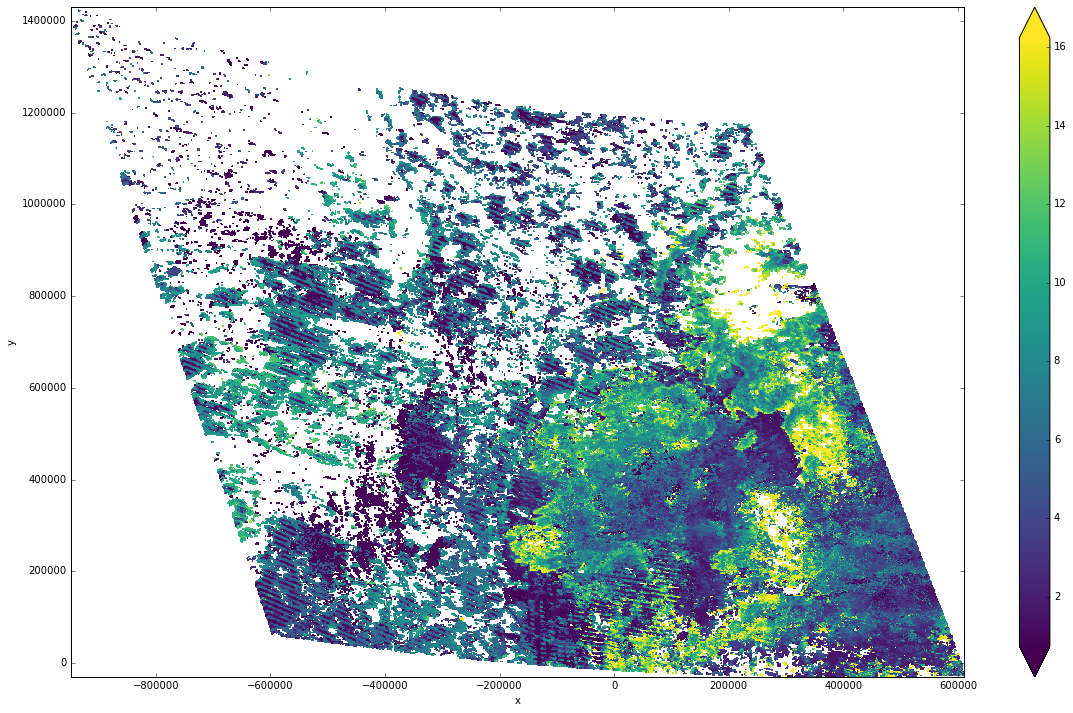

In [14]:
figure(figsize=(20, 12))
overall_mean.plot(robust=True)

In [13]:
xarray_to_rasterio(overall_mean, r'D:\Annies_Dissertation\MAIAC_Test\Projected\2014\overall_mean_out.tif')

## Averages
### Monthly

In [15]:
monthly = PM25.groupby('time.month').max(dim='time')

In [16]:
monthly.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * month    (month) int64 1 3

In [18]:
monthly.attrs

OrderedDict([('crs', '+init=epsg:27700'),
             ('affine',
              (-947639.6305106478,
               1256.5430440955893,
               0.0,
               1429277.8120091767,
               0.0,
               -1256.5430440955893))])

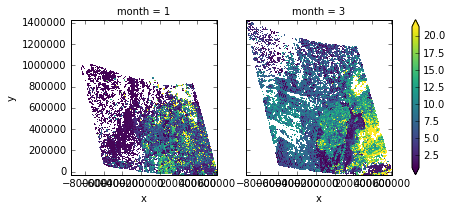

In [19]:
figure(figsize=(20, 12))
monthly.plot(col='month', robust=True)

### Seasonal

In [20]:
seasonal = PM25.groupby('time.season').max(dim='time')

In [21]:
seasonal.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * season   (season) object 'DJF' 'MAM'

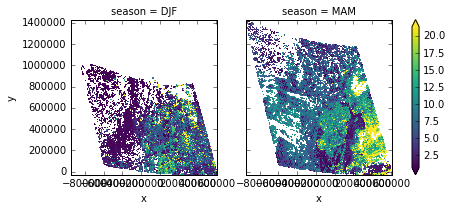

In [22]:
figure(figsize=(20, 12))
seasonal.plot(col='season', robust=True)

### Yearly

In [23]:
yearly = PM25.groupby('time.year').max(dim='time')

In [24]:
yearly.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * year     (year) int64 2000 2012 2013 2014

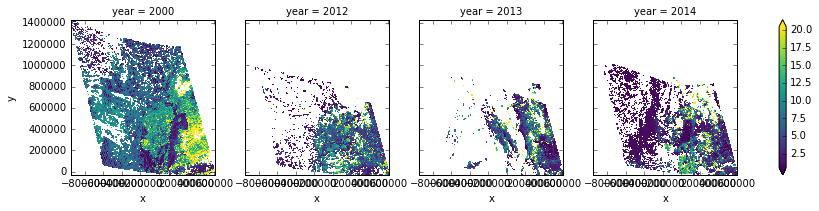

In [25]:
figure(figsize=(20, 12))
yearly.plot(col='year', robust=True)

## Standard deviation of AP for each pixel over time- not currently what i want to do!

In [32]:
std = PM25.groupby('time.year').std(dim = 'time')

In [33]:
std.coords

Coordinates:
  * x        (x) float64 -9.476e+05 -9.464e+05 -9.451e+05 -9.439e+05 ...
  * y        (y) float64 1.429e+06 1.428e+06 1.427e+06 1.426e+06 1.424e+06 ...
  * year     (year) int64 2000 2012 2013 2014

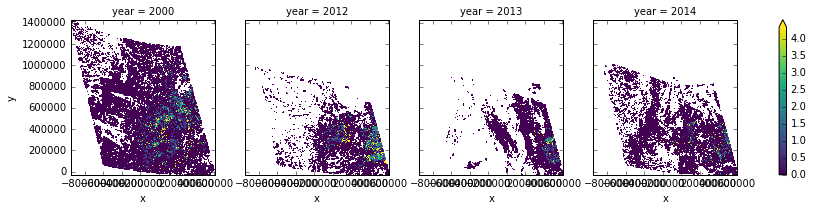

In [36]:
figure(figsize=(20, 12))
std.plot(col='year', robust=True)

# Count of values that aren't missing

In [30]:
observations = PM25.count(dim='time')

(array([  1.24362400e+06,   8.82780000e+04,   4.74370000e+04,
          2.85240000e+04,   1.67750000e+04,   9.42100000e+03,
          4.58400000e+03,   1.69400000e+03,   4.60000000e+02,
          8.30000000e+01]),
 array([  0. ,   1.1,   2.2,   3.3,   4.4,   5.5,   6.6,   7.7,   8.8,
          9.9,  11. ]),
 <a list of 10 Patch objects>)

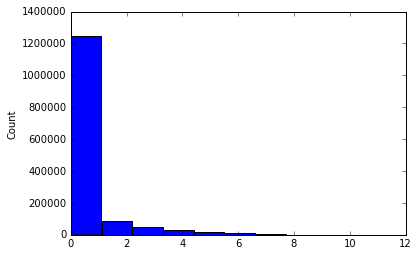

In [31]:
observations.plot.hist()

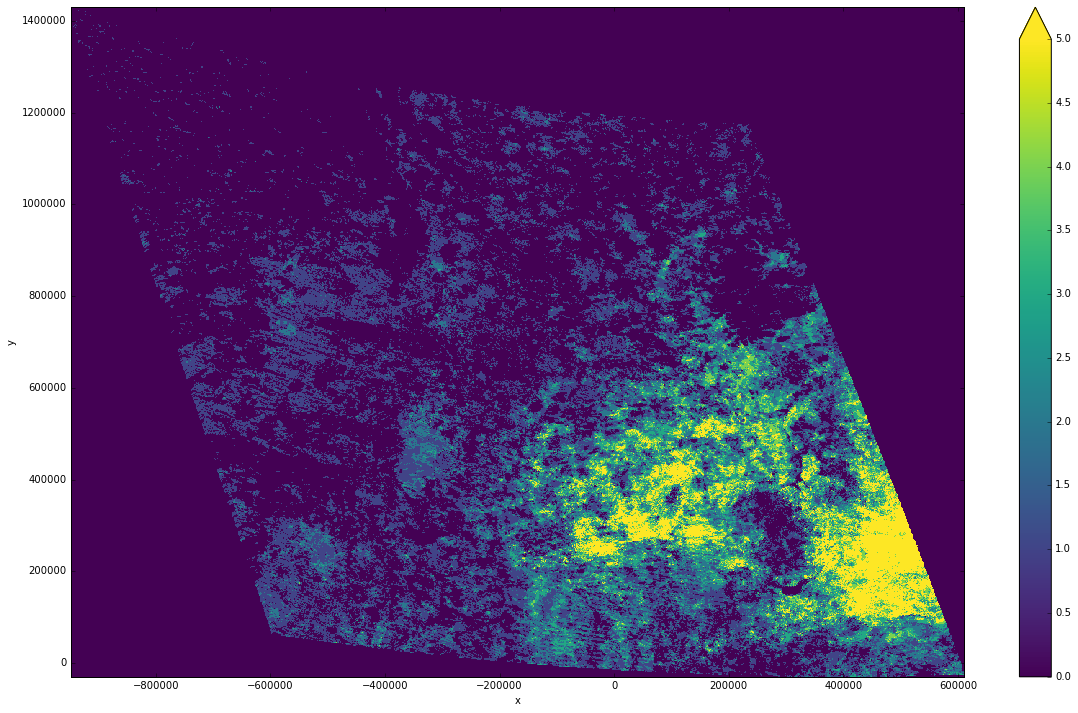

In [32]:
figure(figsize=(20, 12))
observations.plot(robust=True)

# Zonal Statistics

In [33]:
from rasterstats import zonal_stats
zonal_stats(r"D:\Annies_Dissertation\Data\LSOA\LSOA.shp", yearly,
            stats="count min mean max median")

ImportError: No module named 'rasterstats'